## Libraries

In [84]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Read data

In [85]:
train_df = pd.read_csv("./input/train.csv", nrows = 10_000_000) # 55M rows available
train_df = train_df.drop("key", axis = 1)
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...
9999995,5.7,2012-08-12 01:18:00 UTC,-73.999464,40.728452,-73.993299,40.742100,2
9999996,5.5,2013-08-07 10:28:00 UTC,-73.968467,40.759367,-73.964967,40.769027,1
9999997,14.0,2013-10-29 08:29:00 UTC,-73.997952,40.733717,-73.973448,40.759122,5
9999998,10.5,2012-04-07 16:41:33 UTC,-73.992700,40.752021,-73.964705,40.772849,1


In [ ]:
train_df = train_df.dropna(axis = 0)

# ----------- Drop rows outside value ranges -----------
train_df = train_df[train_df["pickup_longitude"].between(-75, -73)]
train_df = train_df[train_df["dropoff_longitude"].between(-75, -73)]
train_df = train_df[train_df["pickup_latitude"].between(40, 42)]
train_df = train_df[train_df["dropoff_latitude"].between(40, 42)]
train_df = train_df[train_df["passenger_count"].between(0, 8)]
train_df = train_df[train_df["fare_amount"].between(0, 250)]

## Visualize

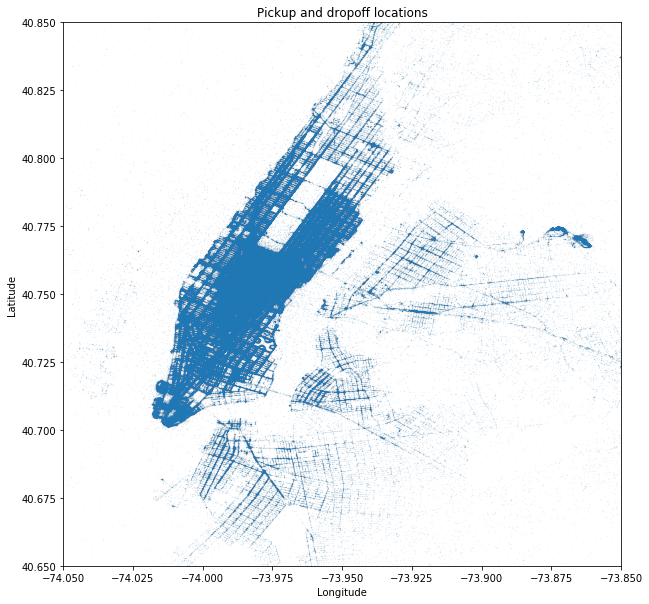

In [13]:
longitude = list(train_df["pickup_longitude"]) + list(train_df["dropoff_longitude"])
latitude = list(train_df["pickup_latitude"]) + list(train_df["dropoff_latitude"])

plt.figure(figsize = (10, 10))
plt.scatter(longitude, latitude, s = 0.05, marker = ".", alpha = 0.25)
plt.ylim((40.65, 40.85))
plt.xlim((-74.05, -73.85))
plt.title("Pickup and dropoff locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Feature engineering

In [87]:
def manh_dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    dist = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)   
    return dist

def transform(data):    
    # ----------- Dates -----------
    data["pickup_datetime"] = data["pickup_datetime"].str.slice(0, 16)
    data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], utc = True, format = "%Y-%m-%d %H:%M")
    
    data["hour"] = data["pickup_datetime"].dt.hour
    data["day"] = data["pickup_datetime"].dt.day
    data["month"] = data["pickup_datetime"].dt.month
    data["year"] = data["pickup_datetime"].dt.year
    
    data = data.drop("pickup_datetime", axis = 1)
    
    # ----------- Travel distances -----------
    data["long_dist"] = data["pickup_longitude"] - data["dropoff_longitude"]
    data["lat_dist"] = data["pickup_latitude"] - data["dropoff_latitude"]
    
    data["dist"] = manh_dist(
        data["pickup_latitude"], data["pickup_longitude"],
        data["dropoff_latitude"], data["dropoff_longitude"]
    )
        
    # ----------- Locations of interest -----------
    nyc = (-74.0063889, 40.7141667) # New York Central
    jfk = (-73.7822222222, 40.6441666667) # John F. Kennedy International Airport
    ewr = (-74.175, 40.69) # Newark Liberty International Airport 
    lgr = (-73.87, 40.77) # LaGuardia Airport
    
    # ----------- Distances to locations to interest -----------
    data["distance_to_center"] = manh_dist(
        nyc[1], nyc[0],
        data["pickup_latitude"], data["pickup_longitude"]
    )
    data["pickup_distance_to_jfk"] = manh_dist(
        jfk[1], jfk[0],
        data["pickup_latitude"], data["pickup_longitude"]
    )
    data["dropoff_distance_to_jfk"] = manh_dist(
        jfk[1], jfk[0],
        data["dropoff_latitude"], data["dropoff_longitude"]
    )
    data["pickup_distance_to_ewr"] = manh_dist(
        ewr[1], ewr[0], 
        data["pickup_latitude"], data["pickup_longitude"]
    )
    data["dropoff_distance_to_ewr"] = manh_dist(
        ewr[1], ewr[0],
        data["dropoff_latitude"], data["dropoff_longitude"]
    )
    data["pickup_distance_to_lgr"] = manh_dist(
        lgr[1], lgr[0],
        data["pickup_latitude"], data["pickup_longitude"]
    )
    data["dropoff_distance_to_lgr"] = manh_dist(
        lgr[1], lgr[0],
        data["dropoff_latitude"], data["dropoff_longitude"]
    )
        
    return data

train_df = transform(train_df)
train_df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,long_dist,lat_dist,dist,distance_to_center,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,-0.002701,0.009041,0.011742,0.169230,0.139241,0.127499,0.362008,0.355668,0.074370,0.086112
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,-0.036780,-0.070701,0.107481,0.012523,0.300962,0.334883,0.180255,0.287736,0.204745,0.121272
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,0.008504,0.010708,0.019212,0.070754,0.317619,0.315415,0.263532,0.244320,0.121468,0.140680
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,0.004437,-0.024949,0.029386,0.038235,0.293884,0.323270,0.231013,0.251525,0.153987,0.133475
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,-0.011440,-0.015754,0.027194,0.092135,0.309714,0.314028,0.284913,0.312107,0.100087,0.100417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,5.7,-73.999464,40.728452,-73.993299,40.742100,2,1,12,8,2012,-0.006165,-0.013648,0.019813,0.021210,0.301527,0.309010,0.213988,0.233801,0.171012,0.151199
9999996,5.5,-73.968467,40.759367,-73.964967,40.769027,1,10,7,8,2013,-0.003500,-0.009660,0.013160,0.083122,0.301445,0.307605,0.275900,0.289060,0.109100,0.095940
9999997,14.0,-73.997952,40.733717,-73.973448,40.759122,5,8,29,10,2013,-0.024504,-0.025405,0.049909,0.027987,0.305280,0.306181,0.220765,0.270674,0.164235,0.114326
9999998,10.5,-73.992700,40.752021,-73.964705,40.772849,1,16,7,4,2012,-0.027995,-0.020828,0.048823,0.051543,0.318332,0.311165,0.244321,0.293144,0.140679,0.097554


## Train model

In [89]:
x_train, x_val, y_train, y_val = train_test_split(
    train_df.drop("fare_amount", axis = 1),
    train_df["fare_amount"],
    test_size = 0.25
)

del(train_df)

train_xgb = xgb.DMatrix(x_train, label = y_train)
val_xgb = xgb.DMatrix(x_val)

del(x_train)
del(x_val)

def xgb_func(max_depth, gamma, colsample_bytree):
    params = {
        "eval_metric": "rmse",
        "max_depth": int(max_depth),
        "subsample": 0.8,
        "eta": 0.1,
        "gamma": gamma,
        "colsample_bytree": colsample_bytree,
        "tree_method" : "gpu_hist"
    }    
    cv_result = xgb.cv(
        params,
        train_xgb,
        num_boost_round = 500,
        nfold = 3
    )      
    # ----------- Optimizer can only maximize so use negative RMSE -----------
    return -1.0 * cv_result["test-rmse-mean"].iloc[-1]


optimizer = BayesianOptimization(
    f = xgb_func,
    pbounds = {"max_depth": (3, 7), "gamma": (0, 1), "colsample_bytree": (0.3, 0.9)}
)

optimizer.maximize(
    init_points = 3,
    n_iter = 5,
    acq = "ei" # expected improvement acquisition function
)

|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------
|  1        | -3.66     |  0.6786   |  0.4474   |  4.855    |
|  2        | -3.557    |  0.499    |  0.3479   |  6.138    |
|  3        | -3.582    |  0.3036   |  0.7911   |  6.601    |
|  4        | -3.517    |  0.9      |  0.0      |  7.0      |
|  5        | -3.548    |  0.3      |  0.0      |  7.0      |
|  6        | -3.543    |  0.9      |  0.0      |  6.548    |
|  7        | -3.825    |  0.3      |  0.0      |  3.0      |
|  8        | -3.518    |  0.9      |  0.4846   |  7.0      |


In [91]:
print(optimizer.max)

{'target': -3.5168696666666666, 'params': {'colsample_bytree': 0.9, 'gamma': 0.0, 'max_depth': 7.0}}


In [92]:
# ----------- Train new model with best parameters -----------
colsample_bytree = optimizer.max["params"]["colsample_bytree"]
gamma = optimizer.max["params"]["gamma"]
max_depth = optimizer.max["params"]["max_depth"]

params = {
    "eval_metric": "rmse",
    "max_depth": int(max_depth),
    "subsample": 0.8,
    "eta": 0.1,
    "gamma": gamma,
    "colsample_bytree": colsample_bytree,
    "tree_method" : "gpu_hist"
}    

model = xgb.train(params, train_xgb, num_boost_round = 500)

## Evaluation

In [98]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

preds_train = model.predict(train_xgb)
preds_val = model.predict(val_xgb)

print(f"Train loss: {rmse(y_train, preds_train):.3f}")
print(f"Val loss: {rmse(y_val, preds_val):.3f}")

Train loss: 3.265
Val loss: 3.510


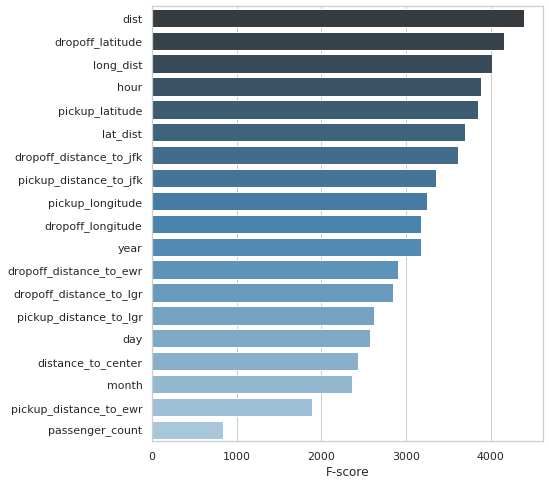

In [94]:
imp_df = pd.DataFrame({
    "variables": list(model.get_fscore().keys()),
    "fscores": list(model.get_fscore().values())
})
imp_df = imp_df.sort_values("fscores", ascending = False)

sns.set(style = "whitegrid")
plt.figure(figsize = (7, 8))
sns.barplot("fscores", "variables", data = imp_df, palette = "Blues_d")
plt.xlabel("F-score")
plt.ylabel("")
plt.show()

## Prediction

In [96]:
test_df = pd.read_csv("./input/test.csv")
test_df = test_df.set_index("key")

test_df = transform(test_df)

test_xgb = xgb.DMatrix(test_df)
preds_test = model.predict(test_xgb)

print("Test loss: 3.084")

Test loss: 3.084


## Submission

In [97]:
test_df = pd.DataFrame({"key": test_df.index, "fare_amount": preds_test})
test_df.to_csv("submission.csv", index = False)

test_df.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.393628
1,2015-01-27 13:08:24.0000003,10.770095
2,2011-10-08 11:53:44.0000002,4.805698
3,2012-12-01 21:12:12.0000002,8.472575
4,2012-12-01 21:12:12.0000003,15.207246
